#### Imports

In [28]:
# Set up file paths
MODEL_PATH = "./models/atari_alien_rr4_reset_dqn_3"
LOG_PATH = "./logs/sb3_atari_dqn_3"

# Imports
## numpy
import numpy as np
## pytorch
import torch
import torch.nn as nn
## stable-baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor # required for minigrid
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed # may be required for seeded approaches
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
## gymnasium
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)
# from gymnasium.wrappers import FrameStackObservation, ClipReward
## plotly and pyplot
import matplotlib.pyplot as plt

#### Variables

In [44]:
n_stack = 4 # run updates once every 4 frames (stack 4 environments for the model to train on)
eval_freq = 5000 # once every eval_freq timesteps, evaluate the model
timesteps = 100000 # game timesteps
replay_ratio = 4 # run gradient calculations 4 times per step
reset_interval = 10000 # reset a part of the buffer at this timestep
env_type = "AlienNoFrameskip-v4" # use this emulation from Gymnasium environments

In [6]:
policy_kwargs = dict()
# policy_kwargs.update(num_agent=1)
# policy_kwargs.update(action_select_coef=50)

#### Callback Setup

In [3]:
# Function to reset weights
def reset_weights(layer):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        layer.reset_parameters()

# Custom callback to reset weights during training
class ResetWeightsCallback(BaseCallback):
    def __init__(self, reset_interval, verbose=0):
        super().__init__(verbose)
        self.reset_interval = reset_interval  # Number of steps between resets

    def _on_step(self) -> bool:
        # Reset weights every reset_interval steps
        if self.n_calls % self.reset_interval == 0: # n_calls inherited from BaseCallback
            if self.verbose > 0:
                print(f"Policy weight reset at: {self.n_calls}")
            # Reset q_net and q_net_target
            self.model.policy.q_net.apply(reset_weights)
            self.model.policy.q_net_target.apply(reset_weights)
        return True

#### Environment and Model Setup

In [5]:
env = make_atari_env(env_type, n_envs=n_stack) # seed can be used here
env = VecFrameStack(env, n_stack= n_stack)
eval_env = make_atari_env(env_type, n_envs= n_stack) # seed can be used here, different than env's seed
eval_env = VecFrameStack(eval_env, n_stack= n_stack)

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


In [7]:
# Using DQN implementation of Stable-Baselines3 with modified callbacks

# callback frequencies are scaled to stack counts to match the given actual game timestep
eval_callback = EvalCallback(env, best_model_save_path=LOG_PATH, log_path=LOG_PATH,
                             eval_freq=max(eval_freq // n_stack, 1), deterministic=True,
                             render=True)
# Create and attach the callback
reset_callback = ResetWeightsCallback(reset_interval=max(reset_interval // n_stack, 1), verbose=1)

callback_list = CallbackList([eval_callback, reset_callback])

model = DQN(
    policy= "CnnPolicy", 
    env= env, 
    verbose= 1, 
    buffer_size= timesteps,
    learning_starts= 2000,
    tau= 0.005,
    train_freq= (1, "step"),
    gradient_steps= replay_ratio,
    target_update_interval= 1,
    policy_kwargs= policy_kwargs,
    tensorboard_log="./dqn_tensorboard_logs/atari",
    )

#### Run Model

In [ ]:
# need reset, reset_frequency and all_reset
model.learn(
    total_timesteps=timesteps,
    callback=callback_list
    )

Using cuda device
Wrapping the env in a VecTransposeImage.


/home/kobot/.local/lib/python3.10/site-packages/stable_baselines3/dqn/dqn.py:157: UserWarning: The number of environments used is greater than the target network update interval (4 > 1), therefore the target network will be updated after each call to env.step() which corresponds to 4 steps.
  warnings.warn(


Logging to ./dqn_tensorboard_logs/atari/DQN_1


/home/kobot/.local/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x713357d31a50> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x71342c232950>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.898    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 807      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1076     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.1e+03  |
|    ep_rew_mean      | 200      |
|    exploration_rate | 0.806    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 746      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2044     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00868  |
|    n_updates        | 40       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.26e+03 |
|    ep_rew_mean      | 157      |
|    exploration_rat

In [9]:
env.close()
eval_env.close()

In [10]:
model.save(MODEL_PATH) 

#### Evaluation

In [11]:
model = DQN.load(MODEL_PATH, env= env) # use this cell if you already have a trained model

Wrapping the env in a VecTransposeImage.


shapes --- timesteps: (20,), results: (20, 5), ep_lengths: (20, 5)


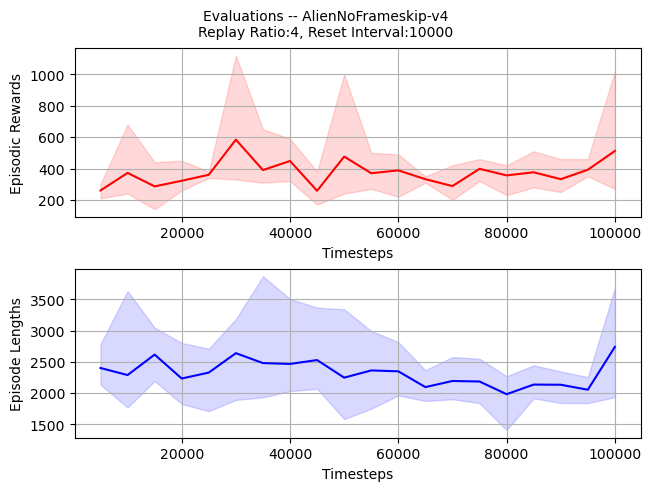

In [52]:
# See evaluation results
with np.load(LOG_PATH+"/evaluations.npz") as eval_data:
    timesteps = eval_data['timesteps']
    results = eval_data['results']
    ep_lengths = eval_data['ep_lengths']

    print(f"shapes --- timesteps: {timesteps.shape}, results: {results.shape}, ep_lengths: {ep_lengths.shape}") # 5 evaluations per step
    # get statistics
    mean_results = np.mean(results, axis=1)
    mean_ep_lengths = np.mean(ep_lengths, axis=1)

    std_results = np.std(results,axis=1)
    std_ep_lengths = np.std(ep_lengths, axis=1)

    min_results = results.min(axis=1)
    max_results = results.max(axis=1)

    min_ep_lengths = ep_lengths.min(axis=1)
    max_ep_lengths = ep_lengths.max(axis=1)    

    var_results = np.stack((mean_results - min_results, max_results - mean_results))
    var_ep_lengths = np.stack((mean_ep_lengths - min_ep_lengths, max_ep_lengths - mean_ep_lengths))

    # Variables that can be controlled
    ## n_stack # run updates once every 4 frames (stack 4 environments for the model to train on)
    ## eval_freq # once every eval_freq timesteps, evaluate the model
    ## timesteps # game timesteps
    ## replay_ratio # run gradient calculations 4 times per step
    ## reset_interval # reset a part of the buffer at this timestep

    fig, ax = plt.subplots(layout="constrained", nrows=2, ncols=1) #, dpi=1000
    fig.suptitle(f"Evaluations -- {env_type}\nReplay Ratio:{replay_ratio}, Reset Interval:{reset_interval}",fontsize=10)
    # Rewards
    ax[0].plot(timesteps, mean_results, color="red")
    ax[0].fill_between(timesteps, min_results, max_results, alpha=0.15, color='red')
    ax[0].grid()
    ax[0].set_xlabel("Timesteps",fontsize=10)
    ax[0].set_ylabel("Episodic Rewards",fontsize=10)
    # Episode lengths
    ax[1].plot(timesteps, mean_ep_lengths, color="blue")
    ax[1].fill_between(timesteps, min_ep_lengths, max_ep_lengths, alpha=0.15, color='blue')
    ax[1].set_xlabel("Timesteps",fontsize=10)
    ax[1].set_ylabel("Episode Lengths",fontsize=10)
    ax[1].grid()
    

#### Code Scraps

In [47]:
# Attempt obtaining evaluation separately -- alternative approach (yields zeroes for some reason)
eval_eps = 10
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=eval_eps)
vec_env = model.get_env()
obs = vec_env.reset()
for i in range(eval_eps):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")

print(f"mean_reward: {mean_reward}, std_reward:{std_reward}")
vec_env.close()

mean_reward: 0.0, std_reward:0.0
